In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science
## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader

<hr style="height:2pt">



In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [21 pts]**](#part1)


- [**Question 2: Bagging [20 pts]**](#part2) 


- [**Question 3: Random Forests [14 pts]**](#part3) 


- [**Question 4: Boosting [30 pts]**](#part4) 


- [**Question 5: Understanding [15 pts]**](#part5) 
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [4]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [21 pts]</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set. Set `random_state=0`.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.

**IMPORTANT:** Throughout this assignment, you should set `random_state=0` in any model that takes such an argument to ensure reproducible results.
</div>

_Points:_ 7

In [5]:
train_scores = []
cvmeans = []
cvstds = []


for depth in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=0)
    
    tree.fit(X_train, y_train)

    train_scores.append(tree.score(X_train, y_train))

    cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
    cvmeans.append(np.mean(cv_scores))
    cvstds.append(np.std(cv_scores))

In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

_Points:_ 7

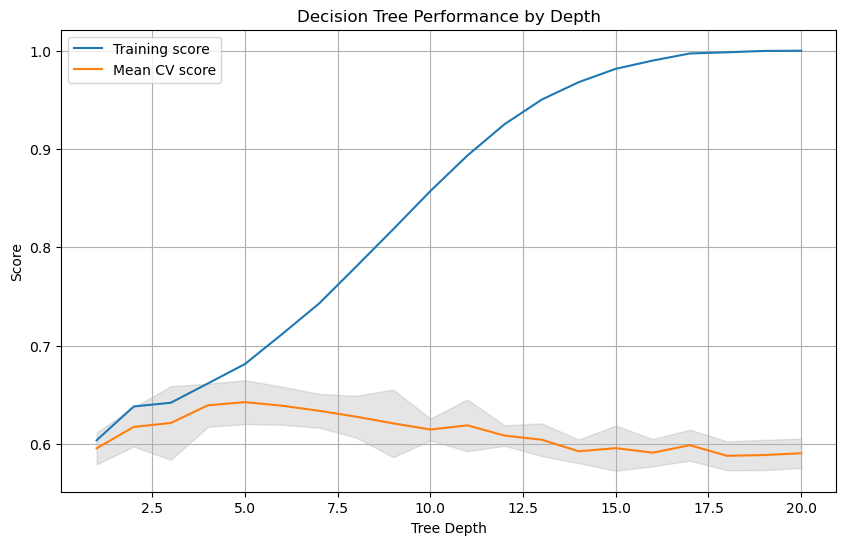

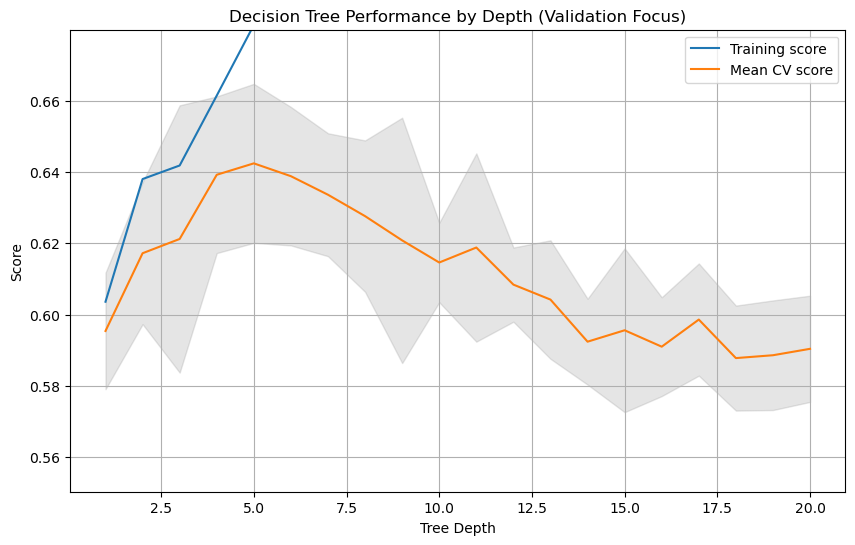

In [7]:
# your code here
# Tree depths
depths = range(1, 21)

# First plot without y-axis limits
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training score')
plt.plot(depths, cvmeans, label='Mean CV score')
plt.fill_between(depths, np.array(cvmeans) - 2*np.array(cvstds), np.array(cvmeans) + 2*np.array(cvstds), 
                 color='gray', alpha=0.2)
plt.title('Decision Tree Performance by Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Second plot with y-axis limits focusing on validation performance
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training score')
plt.plot(depths, cvmeans, label='Mean CV score')
plt.fill_between(depths, np.array(cvmeans) - 2*np.array(cvstds), np.array(cvmeans) + 2*np.array(cvstds), 
                 color='gray', alpha=0.2)
plt.title('Decision Tree Performance by Depth (Validation Focus)')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.ylim(min(cvmeans) - 2*max(cvstds), max(cvmeans) + 2*max(cvstds))  # Setting y-axis limits
plt.legend()
plt.grid(True)
plt.show()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

_Points:_ 4

_Based on the cross-validation results from this data, the most appropriate tree depth for future, unseen data is 5. This is the depth at which the mean cross-validation score was the highest. This approach balances the trade-off between underfitting and overfitting._

In [8]:
# your code here
# choose best depth after a qualitative assessment of our plots
best_cv_depth = np.argmax(cvmeans) + 1
best_tree = DecisionTreeClassifier(max_depth=best_cv_depth, random_state=0)
best_tree.fit(X_train, y_train)
best_cv_tree_train_score = best_tree.score(X_train, y_train)
best_cv_tree_test_score = best_tree.score(X_test, y_test)

In [9]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 5 trained on the full training set, achieves the following accuracy scores:

	train	0.6812
	TEST	0.6480


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

_Points:_ 3

_Limiting the tree depth in a decision tree helps avoid overfitting by reducing the model's complexity, which in turn lowers variance at the cost of increasing bias. This means the model is less likely to capture noise and peculiarities in the training data. However, a key downside of limiting tree depth is that it can lead to underfitting, where the model becomes too simplistic and fails to capture important patterns and relationships in the data, thus increasing bias._

<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [20 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

_Points:_ 3

_A depth where the training score is high but the cross-validation mean score is relatively lower would be indicative of overfitting. One such example is tree depth of 19 since there is a significant difference here between the training accuracy and the CV accuracy suggesting significantly better performance on training, a sign of overfitting._

In [10]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 19

In [11]:
overfit_tree = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
overfit_tree.fit(X_train, y_train)
overfit_tree_train_score = overfit_tree.score(X_train, y_train)
overfit_tree_test_score = overfit_tree.score(X_test, y_test)

<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- **Using a random seed of 0**, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

_Points:_ 1

In [12]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth,
            random_state=0
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [13]:
# specify number of required bootrapped trees
n_trees = 55 

In [14]:
# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees=n_trees,
    tree_depth=tree_depth,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    random_seed=0
)

In [15]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
1,0,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,0,1,0,1,1
3,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,1,1,1,0,1,0,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0


In [16]:
grader.check("q2.2")

q2.2 results:
    q2.2 - 1 result:
        ❌ Test case failed
        Trying:
            assert bagging_train_df.shape == (5000, 55), 'Check the dimensions of your bagging_train_df'
        Expecting nothing
        ok
        Trying:
            assert bagging_test_df.shape == (5000, 55), 'Check the dimensions of your bagging_test_df'
        Expecting nothing
        ok
        Trying:
            assert len(bagging_models_list) == 55, 'You should have 55 estimators in your bagging_models_list'
        Expecting nothing
        ok
        Trying:
            assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
        Expecting nothing
        **********************************************************************
        Line 4, in q2.2 0
        Failed example:
            assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q2.2 0[3]>", line 1, in <module>
                assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.
        Trying:
            assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
        Expecting nothing
        **********************************************************************
        Line 5, in q2.2 0
        Failed example:
            assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q2.2 0[4]>", line 1, in <module>
                assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

_Points:_ 4

In [17]:
# Calculating the combined prediction for each observation
# A majority vote implies that if the mean of predictions is > 0.5, the combined prediction is 1, otherwise 0

# For training data
bagging_combined_train = np.mean(bagging_train_df, axis=1) > 0.5
bagging_accuracy_train = accuracy_score(y_train, bagging_combined_train)

# For test data
bagging_combined_test = np.mean(bagging_test_df, axis=1) > 0.5
bagging_accuracy_test = accuracy_score(y_test, bagging_combined_test)

bagging_accuracy_train, bagging_accuracy_test



(0.9994, 0.687)

In [18]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-19 achieves the following accuracy scores:

	train	0.9994
	TEST	0.6870

Our prior single depth-5 tree achieved a TEST score of 0.6480.


In [19]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.


**Note**: We are permitted to peek at the test scores here because we just want to understand the general behavior of bagging as we add estimators. We are not using the test scores to perform model selection.

</div>

_Points:_ 7

In [20]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


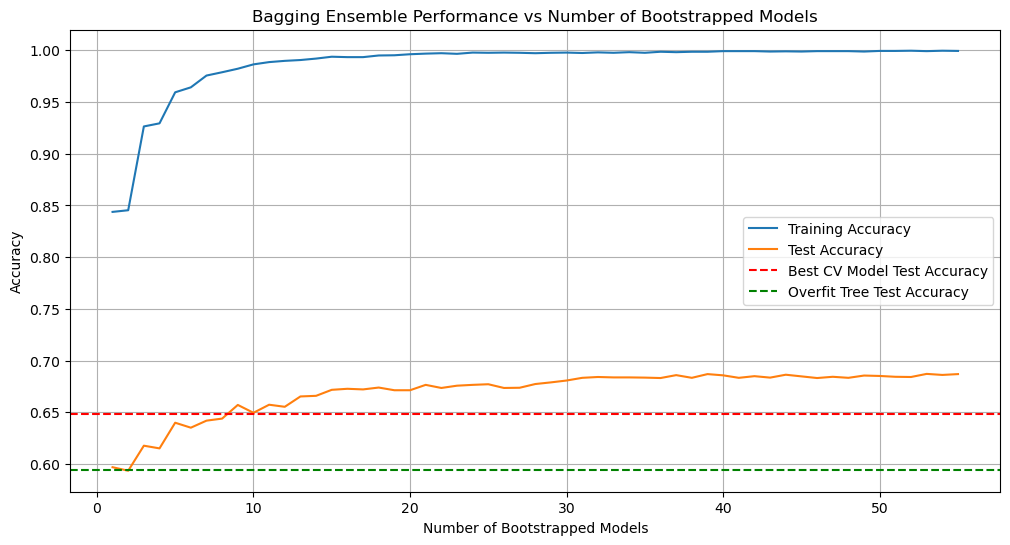

In [21]:
# your code here
# Assuming the running_predictions function, bagging_train_df, and bagging_test_df are defined and available

# Calculate the running accuracies for both the training and test sets
running_accuracy_train = running_predictions(bagging_train_df, y_train)
running_accuracy_test = running_predictions(bagging_test_df, y_test)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 56), running_accuracy_train, label='Training Accuracy')
plt.plot(range(1, 56), running_accuracy_test, label='Test Accuracy')

# Add horizontal lines for the baseline comparisons
# Assuming best_cv_tree_test_score represents the test accuracy of the best model from Question 1
# And assuming that a single decision tree model with the overfit depth has been trained and evaluated
overfit_tree = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
overfit_tree.fit(X_train, y_train)
overfit_tree_test_score = accuracy_score(y_test, overfit_tree.predict(X_test))

plt.axhline(y=best_cv_tree_test_score, color='red', linestyle='--', label='Best CV Model Test Accuracy')
plt.axhline(y=overfit_tree_test_score, color='green', linestyle='--', label='Overfit Tree Test Accuracy')

# Add labels, title, and legend
plt.xlabel('Number of Bootstrapped Models')
plt.ylabel('Accuracy')
plt.title('Bagging Ensemble Performance vs Number of Bootstrapped Models')
plt.legend()
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

_Points:_ 5

_The plot illustrates that the bagging ensemble, which aggregates the predictions of multiple bootstrapped models, effectively mitigates overfitting and enhances generalization when compared to a single overfit decision tree. The bagging ensemble's test accuracy is consistently higher than that of the overfit tree, indicating superior performance on unseen data. This demonstrates the strength of bagging as it leverages the diversity among the overfit models to reduce variance, thereby preventing overfitting while still capturing complex patterns in the data. Unlike simply limiting the tree depth, which can lead to underfitting by overly simplifying the model, bagging maintains the models' complexity and counteracts the risk of overfitting through the wisdom of the ensemble, resulting in a robust predictive performance.._

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

_Points:_ 3

In [22]:
n_features = X_train.shape[1]
max_features = int(np.sqrt(n_features))

# random forest classifier

random_forest = RandomForestClassifier(
    n_estimators=n_trees,
    max_depth=tree_depth,
    max_features=max_features,
    random_state=0)

random_forest.fit(X_train, y_train)

# evaluate results
random_forest_train_score = random_forest.score(X_train, y_train)
random_forest_test_score = random_forest.score(X_test, y_test)

In [23]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-19 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6930


In [24]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

_Points:_ 2

_Random Forest introduces randomness by selecting random subsets of features for splitting in each tree, creating more diverse trees and reducing their correlation. This diversity often leads to a reduction in variance and better generalization on unseen data compared to bagging, which may use all features and result in similar trees. Consequently, Random Forests tend to have higher accuracy on test data due to this enhanced variance reduction without significantly increasing bias, compared to bagging where the trees may be more correlated and less robust to the idiosyncrasies of the training data.._

In [25]:
# Bagging features

feature_counts_bagging = {}

for model in bagging_models_list:
    top_feature = model.tree_.feature[0]
    if top_feature >= 0:
        if top_feature not in feature_counts_bagging:
            feature_counts_bagging[top_feature] = 1
        else:
            feature_counts_bagging[top_feature] += 1

top_predictors_bagging = pd.DataFrame(list(feature_counts_bagging.items()), columns=['Feature', 'Count'])
top_predictors_bagging.set_index('Feature', inplace=True)
top_predictors_bagging.sort_values(by='Count', ascending=False, inplace=True)

# Random Forest features

feature_counts_rf = {}

for estimators in random_forest.estimators_:
    top_feature = estimators.tree_.feature[0]
    if top_feature not in feature_counts_rf:
        feature_counts_rf[top_feature] = 1
    else:
        feature_counts_rf[top_feature] += 1

top_predictors_rf = pd.DataFrame(list(feature_counts_rf.items()), columns=['Feature', 'Count'])
top_predictors_rf.set_index('Feature', inplace=True)
top_predictors_rf.sort_values(by='Count', ascending=False, inplace=True)

# print results
print("Top Predictors in Bagging:")

top_predictors_bagging

Top Predictors in Bagging:


,Count
Feature,
25,55


In [26]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

_Points:_ 5

_On the training set, the single overfit tree and the bagging ensemble exhibit near-perfect accuracy, indicating a likely overfit to the training data. The random forest achieves perfect training accuracy, suggesting it has completely adapted to the training data. On the test set, however, the cross-validated single tree outperforms the overfit single tree due to better generalization. The ensemble methods (bagging and random forest) improve upon the single trees' test accuracies, with the random forest yielding the best performance. This reflects the bias-variance tradeoff: the single overfit tree has high variance and low bias, while the cross-validated tree balances the two. Bagging reduces variance by averaging predictions, but random forest further reduces variance without increasing bias through feature randomness, explaining its superior test accuracy._

In [27]:
# your code here
results = {
    "classifier": [
        "single depth tree chosen by CV",
        "single overfit depth tree",
        "bagging 55 depth trees",
        "random forest of 55 depth trees"
    ],
    "training accuracy": [
        best_cv_tree_train_score,  # from Question 1
        overfit_tree_train_score,  # from Question 2
        bagging_accuracy_train,    # from Question 2
        random_forest_train_score  # from Question 3.1
    ],
    "test accuracy": [
        best_cv_tree_test_score,   # from Question 1
        overfit_tree_test_score,   # from Question 2
        bagging_accuracy_test,     # from Question 2
        random_forest_test_score   # from Question 3.1
    ]
}

# Convert dictionary to DataFrame
results_df = pd.DataFrame(results)

In [28]:
# display results
results_df

,classifier,training accuracy,test accuracy
0,single depth tree chosen by CV,0.6812,0.6480
1,single overfit depth tree,0.9998,0.5944
2,bagging 55 depth trees,0.9994,0.6870
3,random forest of 55 depth trees,1.0000,0.6930


<!-- END QUESTION -->

<a id="part4"></a>
## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

You should be able to identify at least 3 logical/functional issues and 3 stylistic issues.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

_Points:_ 7

In [29]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


Functional Issues:

1. Training Accuracy Calculation: In the training accuracy calculation, the counter `q` is incorrectly reset to 0, skewing accuracy results.
   
2. Test Set Label Reference: The test accuracy check uses `y_train` instead of `y_test`, leading to an invalid accuracy computation.

3. Sample Weight Normalization: The code fails to normalize sample weights after increasing them, which could impact the second tree's fit.

Stylistic Issues:

1. Magic Numbers: The threshold value `.5` is hard-coded; it should be defined as a constant for clarity.

2. Loop for Predictions: The code inefficiently predicts instances in a loop rather than using vectorized operations.

3. Print Statements for Output: The function should return accuracy values, not print them, to allow for flexible use of the output.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.


</div>

_Points:_ 8

In [30]:
# your code here
def simple_boost(X_train, y_train, X_test, y_test):
    tree1 = DecisionTreeClassifier(max_depth=3)
    tree1.fit(X_train, y_train)
    
# Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
    y_train_pred = tree1.predict(X_train)
    sample_weight = np.where(y_train_pred == y_train, 1, 2)
    
# Fit a second depth-3 decision tree using those sample weights
    tree2 = DecisionTreeClassifier(max_depth=3)
    tree2.fit(X_train, y_train, sample_weight=sample_weight)

# Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
    def boosted_predictions(X, tree1, tree2):
        p1 = tree1.predict_proba(X)[:, 1]
        p2 = tree2.predict_proba(X)[:, 1]
        return (p1 + p2) / 2

# Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble
    train_accuracy_tree1 = accuracy_score(y_train, tree1.predict(X_train))
    test_accuracy_tree1 = accuracy_score(y_test, tree1.predict(X_test))

    train_proba_boosted = boosted_predictions(X_train, tree1, tree2)
    test_proba_boosted = boosted_predictions(X_test, tree1, tree2)

    train_accuracy_boosted = accuracy_score(y_train, train_proba_boosted > 0.5)
    test_accuracy_boosted = accuracy_score(y_test, test_proba_boosted > 0.5)

    print("Initial Tree Training Accuracy:", train_accuracy_tree1)
    print("Initial Tree Test Accuracy:", test_accuracy_tree1)
    print("Boosted Training Accuracy:", train_accuracy_boosted)
    print("Boosted Test Accuracy:", test_accuracy_boosted)

simple_boost(X_train, y_train, X_test, y_test)

Initial Tree Training Accuracy: 0.6418
Initial Tree Test Accuracy: 0.6442
Boosted Training Accuracy: 0.6488
Boosted Test Accuracy: 0.651


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

_Points:_ 3

In [31]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=0,
                                                      stratify=y_train)

In [32]:
# your code here
base_learner = DecisionTreeClassifier(max_depth=3)
ada_boost = AdaBoostClassifier(base_estimator=base_learner, n_estimators=800, learning_rate=0.05, algorithm='SAMME.R', random_state=0)

ada_boost.fit(X_train80, y_train80)

train_scores = list(ada_boost.staged_score(X_train80, y_train80))
val_scores = list(ada_boost.staged_score(X_val, y_val))

/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


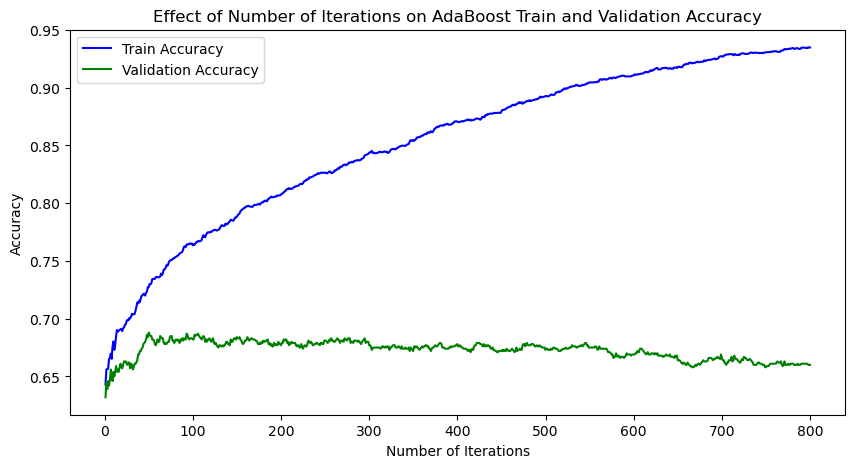

In [33]:
# plot
iterations = list(range(1, 801))

plt.figure(figsize=(10, 5))
plt.plot(iterations, train_scores, color='blue', label='Train Accuracy')
plt.plot(iterations, val_scores, color='green', label='Validation Accuracy')
plt.title('Effect of Number of Iterations on AdaBoost Train and Validation Accuracy')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

_Points:_ 4

_The training accuracy across all depths increases with the number of iterations, reflecting the model's improving fit to the training data. Validation accuracy initially rises but then plateaus, indicating the limit of generalization improvements. With increasing tree depth, the model complexity grows, leading to higher training accuracies but also a risk of overfitting, as seen by the larger gaps between training and validation accuracy for deeper trees. This suggests that while boosting helps correct for misclassifications early on, its effectiveness diminishes with complexity, highlighting the trade-off between bias reduction and variance increase.._

In [34]:
# your code here
train_accuracies = {}
val_accuracies = {}
depths = [1, 2, 3, 4]

for depth in depths:
    base_learner = DecisionTreeClassifier(max_depth=depth)
    ada_boost = AdaBoostClassifier(base_estimator=base_learner, n_estimators=800, learning_rate=0.05, algorithm='SAMME.R', random_state=0)
    
    ada_boost.fit(X_train80, y_train80)

    train_accuracies[depth] = list(ada_boost.staged_score(X_train80, y_train80))
    val_accuracies[depth] = list(ada_boost.staged_score(X_val, y_val))

/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


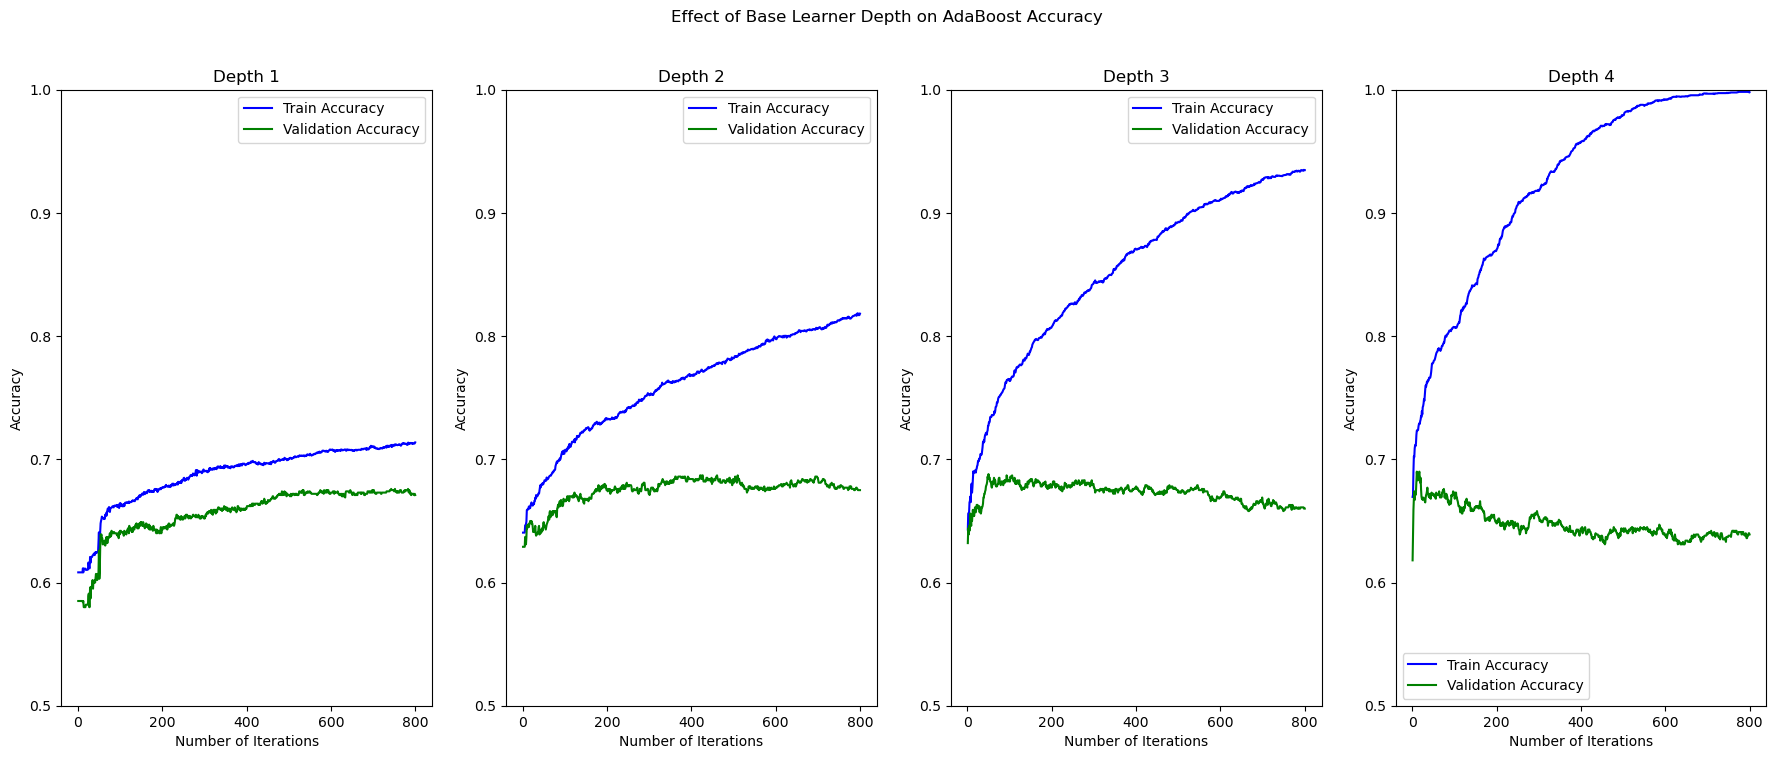

In [35]:
# your code here
# plot

fig, axes = plt.subplots(1, 4, figsize=(22,8))
                         
for i, depth in enumerate(depths):
    axes[i].plot(range(1, 801), train_accuracies[depth], color='blue', label='Train Accuracy')
    axes[i].plot(range(1, 801), val_accuracies[depth], color='green', label='Validation Accuracy')
    axes[i].set_title(f'Depth {depth}')
    axes[i].set_xlabel('Number of Iterations')
    axes[i].set_ylabel('Accuracy')
    axes[i].set_ylim(0.5, 1)
    axes[i].legend()

fig.suptitle('Effect of Base Learner Depth on AdaBoost Accuracy')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

_Points:_ 3

_Based on the plots, an optimal combination appears to be a base learner depth of 2 with a number of iterations around 600. This configuration provides a good balance between training and validation accuracy, indicating strong generalization without significant overfitting. At this point, the validation accuracy plateaus, suggesting that additional iterations do not yield substantial improvements on unseen data. Deeper base learners (depth 3 and 4) show overfitting as evidenced by high training accuracy and lower validation accuracy. Conversely, a depth of 1 seems too simple, as it doesn't achieve as high validation accuracy as depth 2._

In [36]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

_Points:_ 5

_Type your answer here, replacing this text._

In [ ]:
# your code here
base_learner_4 = DecisionTreeClassifier(max_depth=3)
optimal_iterations = 400

ada_boost_final = AdaBoostClassifier(base_estimator=base_learner_4, n_estimators=optimal_iterations, learning_rate=0.05, algorithm='SAMME.R', random_state=0)
ada_boost_final.fit(X_train, y_train)

ada_train_acc = accuracy_score(y_train, ada_boost_final.predict(X_train))
ada_test_acc = accuracy_score(y_test, ada_boost_final.predict(X_test))

/Users/shreyachaturvedi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

<!-- END QUESTION -->

<a id="part5"></a>
## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

_Points:_ 5

_Boosting and bagging are both ensemble techniques that combine multiple models to improve prediction accuracy. Common to both is their method of aggregating the predictions from a group of models to produce a final result, effectively reducing variance. However, their approaches diverge; bagging uses parallel training of models on random subsets of the data, reducing variance by averaging. Boosting, in contrast, trains models sequentially to correct the predecessor's errors, focusing on difficult cases and reducing bias as well as variance. Boosting can overfit if not carefully tuned, while bagging remains more robust but may not improve bias significantly._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.2** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>

_Points:_ 3

_Having too many trees in boosting can lead to overfitting, as each new tree focuses on correcting the residual errors of the entire ensemble, thus potentially amplifying noise. In bagging, adding more trees typically does not result in overfitting; it simply plateaus in performance, as the method averages predictions, which generally smoothens out the noise.._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

_Points:_ 2

_Bagging is better suited to parallelization because its models are trained independently of one another on different subsets of data, allowing simultaneous training on multiple computers. Boosting's sequential model training, which depends on the errors of the previous model, is inherently less parallelizable._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.4** Which of the techniques used in this assignment (i.e., decision trees, bagging, random forest, and boosting) can be extended to regression tasks? Describe how this can be done.

</div>

_Points:_ 5

_All the techniques used in this assignment—decision trees, bagging, random forest, and boosting—can be extended to regression tasks. Instead of predicting a class, they predict a continuous value. Decision trees split based on reduction in variance for regression tasks. Bagging and random forest use averages of predictions from multiple regression trees to make final predictions. Boosting incrementally corrects errors from previous trees, adjusting predictions based on residuals. The core algorithms remain the same, but the criteria for splitting and the final aggregation methods are adapted for numerical prediction._

<!-- END QUESTION -->

**🌈 This concludes HW6. Thank you!**

[Return to contents](#contents)